<a href="https://colab.research.google.com/github/asalimw/Genomic-and-High-Dimensional-Data/blob/main/Mod2_Genomic_and_high_dimensional_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import all the neccessary libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.style.colors import resolve_colors
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist ## distance matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=5, suppress=True)


# **Visualization and Clustering tools**

In this analysis we will analyze a single-cell RNA-seq dataset compiled by the Allen Institute. The data set contains cells from a mouse neocortex (region in the brain which governs perception and cognition).

Each row corresponds to a cell. Each column corresponds to the normalized transcript compatibility count (TCC). We might think of entry i, j as the level of expression of gene j in cell i.

The data consists of a counts matrix  in file Y and X , along with ground truth labels . The ground truth labels are not necessary for this part, but you may use them to verify that your results are sensible.

Goal: Unveil hierarchical structure of the genes and discover important genes.

In [ ]:
# Import data set
X = np.load('/content/drive/MyDrive/Data Analysis MIT/HW2 data/p1/X.npy')
Y = np.load('/content/drive/MyDrive/Data Analysis MIT/HW2 data/p1/y.npy')
print(len(X)) #Number of Cells (number of rows)
print(len(X[0])) #Number of Genes (number of columns)
print(X[:,0].max()) #largest entry in the first column

511
45768
11.941397591320595


**Transform the Data**

Due to the presence of genes with extremely high magnitudes of expression in only a few cells, it is common to apply a log-transform to the data, that is, to apply the transform log2(x+1). Apply this transform to each entry in the raw data.

In [ ]:
# Because of the extremely high magnitude of gene expression in only a few cell,
#  it is common to apply a log-transform to the data.
X_transformed = np.log2(X+1) #apply a log-transform to the data
# print(X_transformed)
np.round(np.max(X_transformed[:,0]), 5)

3.69392

**Principal Components and Explained Variance**

Compute the principal components and what percentage of the variance is explained by the first principal component?
https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

In [ ]:
pca_X = PCA().fit(X)
pca_X_transformed = PCA().fit(X_transformed)
# We now get the percentage of variance explained by the first principal component for the fitted X and fitted X transformed
print('%variance explained by PC1 for X:', round(pca_X.explained_variance_ratio_[0], 5))
print('%variance explained by PC1 for transformed X:', round(pca_X_transformed.explained_variance_ratio_[0], 5))

%variance explained by PC1 for X: 0.4278
%variance explained by PC1 for transformed X: 0.13888


How many PC's are needed to explain 85% of the variance for both raw and processed data? To get a better idea of how the explained variance grow as more PCs are included, plot the cumulative explained variance versus number of PCs.

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

https://vitalflux.com/pca-explained-variance-concept-python-example/


In [ ]:
def plot_cumulative_variance_explained(fitted_data):
    n_features = fitted_data.components_.shape[0]
    plt.plot(np.arange(1, n_features+1), np.cumsum(fitted_data.explained_variance_ratio_))

    plt.title("PCA cumulative variance explained", size=15)
    plt.xticks(np.arange(0, n_features, step=round(n_features/10, -2)))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xlabel('Number of components')
    plt.ylabel('% Variance explained')

    plt.show()

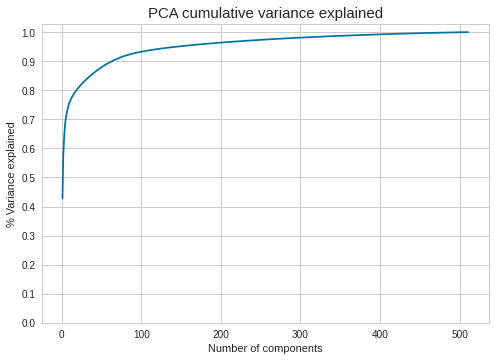

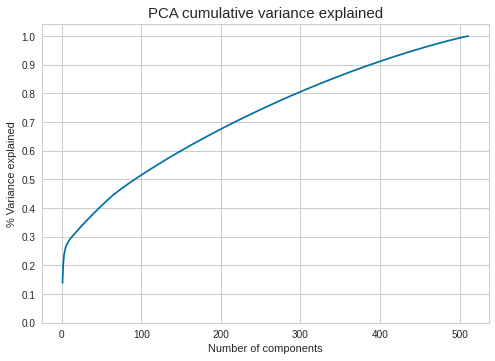

Required #PCs to explained 0.85 of the variance in X: 36
Required #PCs to explained 0.85 of the variance in transformed X: 339


In [ ]:
# We plot the cumulative variance explained to get an idea of how the explained variance grows as more PCs are included
plot_cumulative_variance_explained(pca_X)
plot_cumulative_variance_explained(pca_X_transformed)

# How many PC should we include to explain a given threshold of variance?
threshold = 0.85

nb_PC_X = np.where(np.cumsum(pca_X.explained_variance_ratio_) >= threshold)[0][0]+1
nb_PC_X_transformed = np.where(np.cumsum(pca_X_transformed.explained_variance_ratio_) >= threshold)[0][0]+1

print('Required #PCs to explained {} of the variance in X: {}'.format(threshold, nb_PC_X))
print('Required #PCs to explained {} of the variance in transformed X: {}'.format(threshold, nb_PC_X_transformed))

We first try to visualize the data with no specialized techniques. Make a scatterplot with the first and second coordinates of the data as the axes.

Which of the following plots has the most similar characteristic to the visualization you obtain?

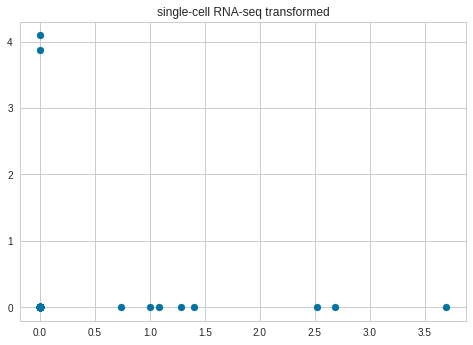

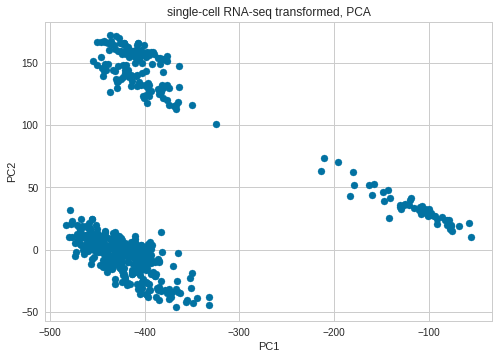

In [ ]:
# We'll now visualize the transformed data. First the raw log-transformed data, 
# then the log-transformed data transformed by PCA
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.title('single-cell RNA-seq transformed')
plt.show()

#Plot the data projected onto PC1 and
projected_onto_PC1 = np.matmul(X_transformed, pca_X_transformed.components_[0])
projected_onto_PC2 = np.matmul(X_transformed, pca_X_transformed.components_[1])

plt.scatter(projected_onto_PC1, projected_onto_PC2)
plt.title('single-cell RNA-seq transformed, PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Multi Dimensional Scaling**

Use the sklearn implementation of MDS to visualize the data in two dimensions.

Which of the following plots has the most similar characteristic to the visualization you obtain?

https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/



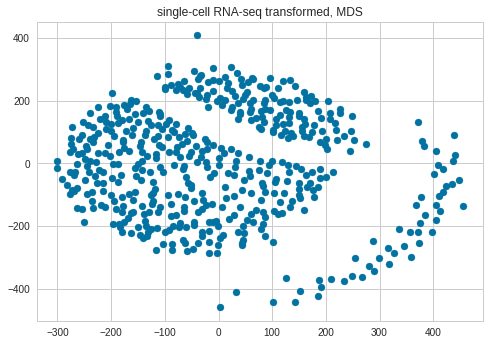

In [ ]:
# We will now visualize the data set in two dimension by reducing it using MDS (Multidimensional Scaling)
mds_X_transformed = MDS(verbose=1, eps=1e-5).fit_transform(X_transformed)

plt.scatter(mds_X_transformed[:,0], mds_X_transformed[:,1])
plt.title('single-cell RNA-seq transformed, MDS')
plt.show()

**T-SNE**

Project the data onto the top  PC's and run T-SNE with a perplexity value of  on the projected data to visualize the data in two dimensions.
Using sklearn.manifold

https://www.programcreek.com/python/example/101756/sklearn.manifold.TSNE
https://matthew-brett.github.io/teaching/pca_introduction.html
https://towardsdatascience.com/a-complete-guide-to-principal-component-analysis-pca-in-machine-learning-664f34fc3e5a

In [ ]:
# We project the data onto the top 50 principal components
projected_onto_top50 = np.matmul(X_transformed, pca_X_transformed.components_[:50].T)

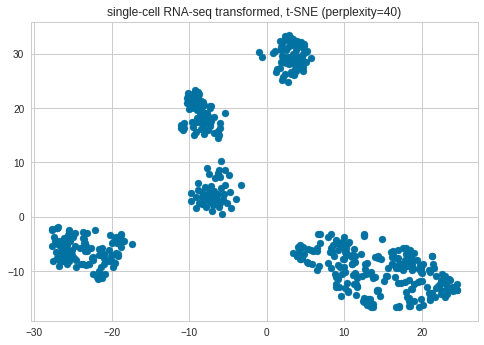

In [ ]:
# Now visualize the dataset after reducing it using t-SNE (top 50 PC)
tsne_top_PC = TSNE(n_components=2, perplexity=40).fit_transform(projected_onto_top50)

plt.scatter(tsne_top_PC[:,0], tsne_top_PC[:,1])
plt.title('single-cell RNA-seq transformed, t-SNE (perplexity=40)')
plt.show()

# **Clustering**

**Visualizing K-means Clustering**

We continue to use the log-transformed data projected onto the top 50 PC's.

Run K-Means on the projected data with the number of clusters by selected by looking at the T-SNE plot.

Redo the PCA, MDS, and T-SNE plots from previous part, but now with colors representing the different cluster identities (e.g. use 10 colors if there are 10 clusters).

**Consider the clusters that you can distinguish visually in the PCA plot. What is the maximum number of K-means clusters (i.e maximum number of colors) in one visual cluster? Ignore outliers.**

https://www.askpython.com/python/examples/plot-k-means-clusters-python

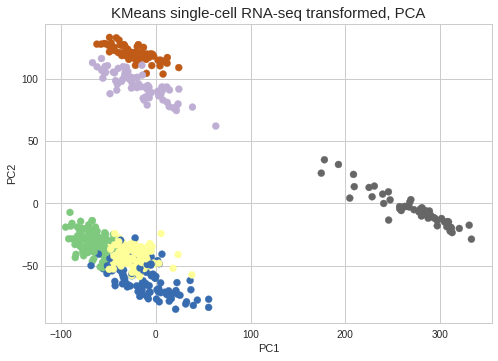

In [ ]:
# We define the number of clusters by looking at the data set reduced using t-SNE
n_clusters = 6
clustering = KMeans(n_clusters=n_clusters, n_init=50).fit(projected_onto_top50)
colors = np.array(resolve_colors(n_clusters, 'Accent'))

pca_X_top50 = PCA().fit_transform(projected_onto_top50)

plt.scatter(pca_X_top50[:,0], pca_X_top50[:,1], c=colors[clustering.labels_])
plt.title('KMeans single-cell RNA-seq transformed, PCA', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

**Consider the clusters that you can distinguish visually in the MDS plot. What is the maximum number of K-means clusters (colors) in one visual cluster in the MDS plot? Ignore outliers.**

https://towardsdatascience.com/visualize-multidimensional-datasets-with-mds-64d7b4c16eaa

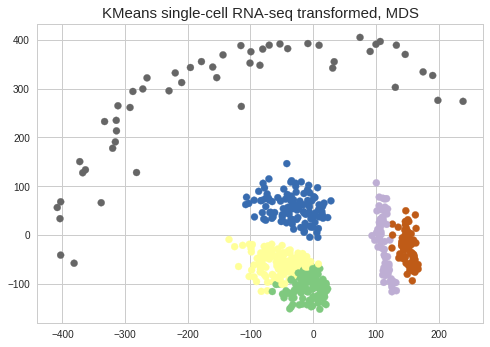

In [ ]:
mds_X_top50 = MDS(verbose=1, eps=1e-5).fit_transform(projected_onto_top50)

plt.scatter(mds_X_top50[:,0], mds_X_top50[:,1], c=colors[clustering.labels_])
plt.title('KMeans single-cell RNA-seq transformed, MDS', size=15)

plt.show()

**Consider the clusters that you can distinguish visually in the T-SNE plot. What is the maximum number of K-means clusters (colors) in one visual cluster in the T-SNE plot? Ignore outliers.**

https://www.reddit.com/r/Python/comments/8tqyvq/how_to_analyze_the_tsnekmeans_result_in_python/

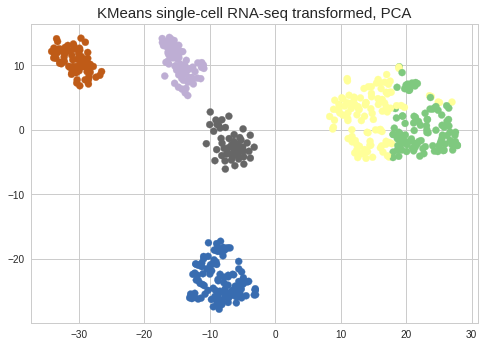

In [ ]:
tsne_X_top50 = TSNE(n_components=2, perplexity=40).fit_transform(projected_onto_top50)

plt.scatter(tsne_X_top50[:,0], tsne_X_top50[:,1], c=colors[clustering.labels_])
plt.title('KMeans single-cell RNA-seq transformed, PCA', size=15)

plt.show()

# **Elbow Method**

*We continue to use the data projected onto the top 50 PC's.*

Use the elbow method to select a number of clusters. In other words, plot the K-Means clustering criterion **WGSS** versus the number of clusters **K**, and find the number of cluster after the last big drop of the curve. 



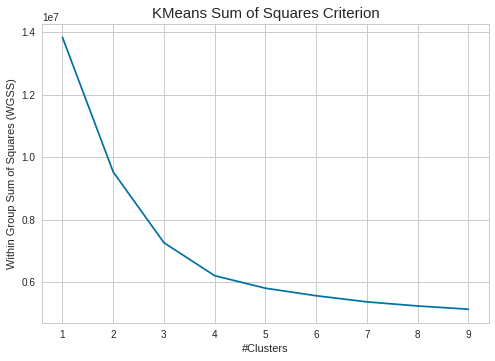

In [ ]:
# How many clusters should we solve for ? We'll answer that by looking at an elbow plot
plt.plot(np.arange(1, 10), [KMeans(i, n_init=50).fit(projected_onto_top50).inertia_ for i in range(1, 10)])
plt.xticks(np.arange(1, 10, step=1))
plt.title('KMeans Sum of Squares Criterion', size=15)
plt.xlabel('#Clusters')
plt.ylabel('Within Group Sum of Squares (WGSS)')

plt.show()

In [ ]:
n_clusters = 4
kmeans_top50 = KMeans(n_clusters, n_init=50).fit(projected_onto_top50)
print('WGSS for {} clusters: {:.3g}'.format(n_clusters, kmeans_top50.inertia_))

# kmeans_centroid_top50 = kmeans_top50.cluster_centers_

WGSS for 4 clusters: 6.2e+06


# **Alternate Scenario**

**What if We Did Not Transform Data**

Consider what would have happened if we did not take a log transform of the data.
Perform the PCA, MDS, and T-SNE visualizations from parts 5 and 7 (with the same parameters) using the original data, before taking the log transform. Which plots look most like the plots you obtain?


In [ ]:
# Centre the X data as we are using the original data
kmeans_X_centroid = KMeans(n_clusters, n_init=50).fit(X_transformed).cluster_centers_

**Perform the PCA visualizations using the original data**

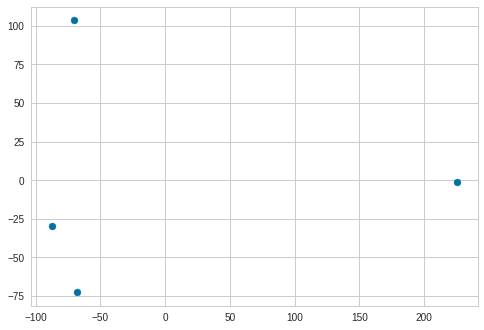

In [ ]:
# Perform the PCA visualizations using the original data
pca_kmeans_X_centroid = PCA().fit_transform(kmeans_X_centroid)

plt.scatter(pca_kmeans_X_centroid[:,0], pca_kmeans_X_centroid[:,1])
plt.show()

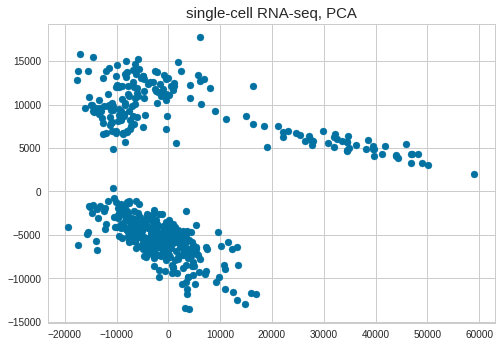

In [ ]:
pca_X = PCA().fit_transform(X)
plt.scatter(pca_X[:,0], pca_X[:,1])
plt.title('single-cell RNA-seq, PCA', size=15)
plt.show()

**Perform the MDS visualizations using the original data**

breaking at iteration 47 with stress 2086.845573761656
breaking at iteration 41 with stress 2086.846752119912
breaking at iteration 104 with stress 2086.846362048437
breaking at iteration 23 with stress 5857.7248504918425


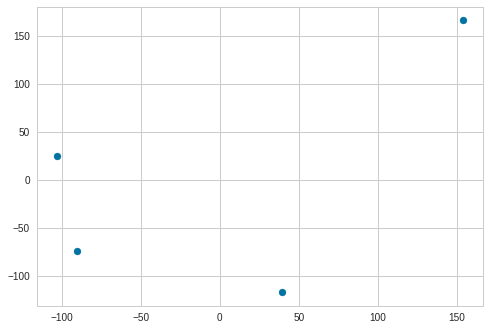

In [ ]:
# Perform the MDS visualizations using the original data
mds_kmeans_X_centroid = MDS(n_components=2, verbose=1, eps=1e-5).fit_transform(kmeans_X_centroid)

plt.scatter(mds_kmeans_X_centroid[:,0], mds_kmeans_X_centroid[:,1])
plt.show()

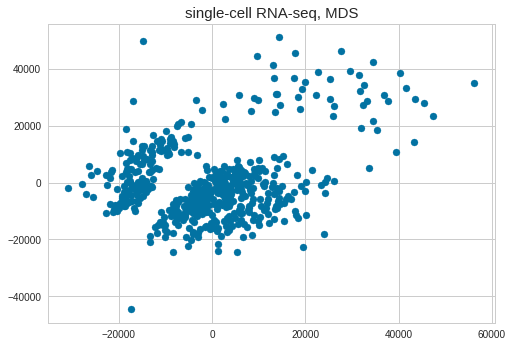

In [ ]:
mds_X = MDS(verbose=1, eps=1e-5).fit_transform(X)

plt.scatter(mds_X[:,0], mds_X[:,1])
plt.title('single-cell RNA-seq, MDS', size=15)
plt.show()

**Perform the T-SNE visualizations using the original data**

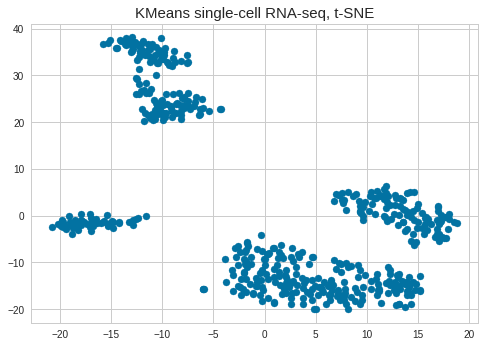

In [ ]:
# Perform the T-SNE visualizations using the original data
tsne_X = TSNE(n_components=2, perplexity=40).fit_transform(X)

plt.scatter(tsne_X[:,0], tsne_X[:,1])
plt.title('KMeans single-cell RNA-seq, t-SNE', size=15)

plt.show()

Data Preparation

Load the data in X.npy and take log-transform log2(x+1) for the data. How many cells and genes are in the transformed data set?

The dataset format: (2169, 45768)
5.972169178513185
